# Ising Demo
In this notebook we will implement some demo DMRG for the transverse Ising model.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

import scipy.sparse as sparse

In [4]:
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

In [64]:
# define a function for Ising
def DMRG_Ising(
    # model parameters
    L=2,
    J=1.,
    gs=np.linspace(.5, 1.5, 21),
    bc_MPS='infinite',
    bc='periodic',
    conserve=None,
    model_verbose=1,
    
    # DMRG parameters 
    chi=100,
    svd_min=1.e-10,
    trunc_cut=None,
    update_env=5,
    start_env=5,
    max_E_err=0.0001,
    max_S_err=0.0001,
    max_sweeps=1000,
    DMRG_verbose=1,
    mixer=True,
    mixer_amplitude=1.e-3,
    mixer_decay=1.2,
    mixer_disable_after=50,
):
    # constructing the model
    model_params = dict(
    L=L,
    J=J,
    g=gs[0],
    bc_MPS=bc_MPS,
    bc=bc,
    conserve=conserve,
    verbose=model_verbose,
    )
    M = TFIChain(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        (["up", "down"] * L)[:L], 
        M.lat.bc_MPS,
    )
    
    # construct the DMRG engine
    dmrg_params = {
        'trunc_params': {
            'chi_max': chi,
            'svd_min': svd_min,
            'trunc_cut': trunc_cut,
        },
        'mixer': mixer,
        'mixer_params': {
            'amplitude': mixer_amplitude,
            'decay': mixer_decay,
            'disable_after': mixer_disable_after,
        },
        'update_env': update_env,
        'start_env': start_env,
        'max_E_err': max_E_err,
        'max_S_err': max_S_err,
        'max_sweeps': max_sweeps,  # NOTE: this is not enough to fully converge at the critical point!
        'verbose': DMRG_verbose,
    }
    engine = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    np.set_printoptions(linewidth=120)
    
    psi_list = []
    corr_length = []
    fidelity = []
    Sz = []
    E = []
    S = []
    SxSx = []
    old_psi = None
    for g in gs:
        print("-" * 80)
        print("g =", g)
        print("-" * 80)
        model_params['g'] = g
        M = TFIChain(model_params)
        engine.init_env(model=M)  # (re)initialize DMRG environment with new model
        # this uses the result from the previous DMRG as first initial guess
        E0, psi = engine.run()
        E.append(E0)
        psi_list.append(psi.copy())
        # psi is modified by engine.run() and now represents the ground state for the current `g`.
        S.append(psi.entanglement_entropy()[0])
        corr_length.append(psi.correlation_length(tol_ev0=1.e-3))
        print("corr. length", corr_length[-1])
        Sz.append(psi.expectation_value('Sigmaz'))
        print("<Sigmaz>", Sz[-1])
        SxSx.append(psi.correlation_function("Sigmax", "Sigmax", [0], 20)[0, :])
        print("<Sigmax_0 Sigmax_i>", SxSx[-1])
        if old_psi is not None:
            fidelity.append(np.abs(old_psi.overlap(psi)))
            print("fidelity", fidelity[-1])
        old_psi = psi.copy()
        dmrg_params['start_env'] = 0  # (some of) the parameters are read out again
    
    results = {
        'model_params': model_params,
        'dmrg_params': dmrg_params,
        'psi_list': psi_list,
        'gs': gs,
        'corr_length': np.array(corr_length),
        'fidelity': np.array(fidelity),
        'Sz': np.array(Sz),
        'E': np.array(E),
        'S': np.array(S),
        'SxSx': np.array(SxSx),
        'eval_transfermatrix': np.exp(-1. / np.array(corr_length)),
    }
    return results

In [65]:
results = DMRG_Ising(
    gs=np.linspace(.5, 1.5, 21),
    chi=200,
    
)

Reading 'bc_MPS'='infinite' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'L'=2 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=0.5 for config TFIChain
Subconfig 'trunc_params'=Config(<4 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=5 for config TwoSiteDMRGEngine
Updating environment
.....
--------------------------------------------------------------------------------
g = 0.5
--------------------------------------------------------------------------------
Reading 'explicit_plus_hc'=False for config TFIChain
Reading 'bc_MPS'='infinite' for config TFIChain
Reading 'order'='default' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'bc_x'='periodic' for config TFIChain
Reading 'L'=2 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=0.5 for config TFIChain
Reading 'sort_mpo_legs'=False for config TFIChain
Initial sweeps...
Updating environment
.....
Reading 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 200
Energy = -1.0635444099733959, S = nan, norm_err = 8.8e-09
Current memory usage 342.3 MB, time elapsed: 1.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4777e-20, max_E_trunc = 2.8422e-14
MPS bond dimensions: [17, 18]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0635444099733533, S = nan, norm_err = 8.6e-09
Current memory usage 342.3 MB, time elapsed: 2.7 s
Delta E = 4.2633e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0423e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [16, 16]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 440
Energy = -1.0635444099734812, S = 0.6960673544902174, norm_err = 8.4e-09
Current memory usage 342.3 MB, time elapsed: 3.2 s
Delta E = -1.2790e-14, Delta S = nan (per sweep)
max_trunc_err = 4.0931e-21, max_E_trunc = 1.1369e-13
MPS bond dimensions: [20, 20]


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/linalg/lanczos.py:250: UserWarning: Poorly conditioned Lanczos!
  warnings.warn("Poorly conditioned Lanczos!")


Updating environment
.....
sweep 40, age = 560
Energy = -1.0635444099734315, S = 0.6252573599310660, norm_err = 1.1e-02
Current memory usage 342.3 MB, time elapsed: 4.1 s
Delta E = 4.9738e-15, Delta S = -7.0810e-03 (per sweep)
max_trunc_err = 2.0980e-20, max_E_trunc = 3.4106e-13
MPS bond dimensions: [21, 20]
Updating environment
.....
sweep 50, age = 680
Energy = -1.0635444099733604, S = 0.2949001896368966, norm_err = 4.1e-03
Current memory usage 342.3 MB, time elapsed: 5.7 s
Delta E = 7.1054e-15, Delta S = -3.3036e-02 (per sweep)
max_trunc_err = 1.7164e-20, max_E_trunc = 6.8212e-13
MPS bond dimensions: [20, 20]
Updating environment
.....
sweep 60, age = 800
Energy = -1.0635444099734173, S = 0.0959079982936829, norm_err = 9.7e-04
Current memory usage 342.3 MB, time elapsed: 7.1 s
Delta E = -5.6843e-15, Delta S = -1.9899e-02 (per sweep)
max_trunc_err = 3.9278e-21, max_E_trunc = 2.2737e-13
MPS bond dimensions: [20, 20]
Updating environment
.....
sweep 70, age = 920
Energy = -1.0635444099

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 1520
Energy = -1.0771779809659279, S = nan, norm_err = 7.3e-08
Current memory usage 342.3 MB, time elapsed: 1.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6000e-20, max_E_trunc = 2.2737e-12
MPS bond dimensions: [13, 11]
Updating environment
.....
sweep 20, age = 1640
Energy = -1.0771779809664110, S = nan, norm_err = 1.4e-08
Current memory usage 342.3 MB, time elapsed: 3.7 s
Delta E = -4.8317e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6297e-20, max_E_trunc = 1.3642e-12
MPS bond dimensions: [10, 11]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 1760
Energy = -1.0771779809659847, S = 0.0043507353487557, norm_err = 2.3e-09
Current memory usage 342.3 MB, time elapsed: 5.3 s
Delta E = 4.2633e-14, Delta S = nan (per sweep)
max_trunc_err = 1.4504e-20, max_E_trunc = 9.0949e-13
MPS bond dimensions: [19, 19]
Updating environment
.....
sweep 40,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 2000
Energy = -1.0922385835542343, S = nan, norm_err = 3.5e-12
Current memory usage 342.3 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.8595e-20, max_E_trunc = -4.5475e-13
MPS bond dimensions: [11, 13]
Updating environment
.....
sweep 20, age = 2120
Energy = -1.0922385835548312, S = nan, norm_err = 8.3e-16
Current memory usage 342.3 MB, time elapsed: 3.4 s
Delta E = -5.9686e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8443e-21, max_E_trunc = -2.2737e-12
MPS bond dimensions: [10, 11]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 2240
Energy = -1.0922385835549449, S = 0.0063407595561299, norm_err = 7.6e-16
Current memory usage 342.3 MB, time elapsed: 3.9 s
Delta E = -1.1369e-14, Delta S = nan (per sweep)
max_trunc_err = 7.1225e-22, max_E_trunc = 1.3642e-12
MPS bond dimensions: [14, 14]
Updating environment
.....
sweep 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 2480
Energy = -1.1087707165125380, S = nan, norm_err = 1.2e-15
Current memory usage 342.3 MB, time elapsed: 1.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9874e-20, max_E_trunc = 3.6380e-12
MPS bond dimensions: [10, 12]
Updating environment
.....
sweep 20, age = 2600
Energy = -1.1087707165125948, S = nan, norm_err = 1.0e-15
Current memory usage 342.3 MB, time elapsed: 3.3 s
Delta E = -5.6843e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0280e-20, max_E_trunc = 9.0949e-13
MPS bond dimensions: [11, 11]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 2720
Energy = -1.1087707165122538, S = 0.0091045120392636, norm_err = 5.1e-16
Current memory usage 342.3 MB, time elapsed: 3.8 s
Delta E = 3.4106e-14, Delta S = nan (per sweep)
max_trunc_err = 1.2872e-20, max_E_trunc = 9.0949e-13
MPS bond dimensions: [14, 14]
Updating environment
.....
sweep 40,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 2960
Energy = -1.1268286675869490, S = nan, norm_err = 7.0e-16
Current memory usage 342.3 MB, time elapsed: 1.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2463e-20, max_E_trunc = 1.8190e-12
MPS bond dimensions: [10, 11]
Updating environment
.....
sweep 20, age = 3080
Energy = -1.1268286675860395, S = nan, norm_err = 3.6e-15
Current memory usage 342.3 MB, time elapsed: 3.5 s
Delta E = 9.0949e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7954e-20, max_E_trunc = 3.6380e-12
MPS bond dimensions: [10, 11]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 3200
Energy = -1.1268286675872901, S = 0.0129615831147453, norm_err = 3.2e-15
Current memory usage 342.3 MB, time elapsed: 4.0 s
Delta E = -1.2506e-13, Delta S = nan (per sweep)
max_trunc_err = 4.4264e-22, max_E_trunc = 9.0949e-13
MPS bond dimensions: [19, 19]
Updating environment
.....
sweep 40,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 3440
Energy = -1.1464797543713985, S = nan, norm_err = 1.8e-15
Current memory usage 342.3 MB, time elapsed: 2.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2845e-20, max_E_trunc = 3.6380e-12
MPS bond dimensions: [13, 16]
Updating environment
.....
sweep 20, age = 3560
Energy = -1.1464797543710006, S = nan, norm_err = 3.6e-15
Current memory usage 342.3 MB, time elapsed: 3.8 s
Delta E = 3.9790e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9121e-20, max_E_trunc = 3.1832e-12
MPS bond dimensions: [13, 12]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 3680
Energy = -1.1464797543682721, S = 0.0184228272524404, norm_err = 1.0e-15
Current memory usage 342.3 MB, time elapsed: 4.4 s
Delta E = 2.7285e-13, Delta S = nan (per sweep)
max_trunc_err = 1.1418e-20, max_E_trunc = 1.3642e-12
MPS bond dimensions: [19, 19]
Updating environment
.....
sweep 40, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 3920
Energy = -1.1678095085222822, S = nan, norm_err = 4.0e-15
Current memory usage 342.3 MB, time elapsed: 2.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0418e-20, max_E_trunc = 8.1855e-12
MPS bond dimensions: [15, 16]
Updating environment
.....
sweep 20, age = 4040
Energy = -1.1678095085220548, S = nan, norm_err = 2.1e-15
Current memory usage 342.3 MB, time elapsed: 3.9 s
Delta E = 2.2737e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1591e-20, max_E_trunc = 7.2760e-12
MPS bond dimensions: [15, 15]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 4160
Energy = -1.1678095085208042, S = 0.0263704265877357, norm_err = 1.6e-15
Current memory usage 342.3 MB, time elapsed: 4.6 s
Delta E = 1.2506e-13, Delta S = nan (per sweep)
max_trunc_err = 1.6723e-21, max_E_trunc = 5.4570e-12
MPS bond dimensions: [25, 25]
Updating environment
.....
sweep 40, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 4400
Energy = -1.1909306781751638, S = nan, norm_err = 5.4e-13
Current memory usage 342.3 MB, time elapsed: 2.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2374e-20, max_E_trunc = 1.8190e-12
MPS bond dimensions: [18, 19]
Updating environment
.....
sweep 20, age = 4520
Energy = -1.1909306781767555, S = nan, norm_err = 4.4e-15
Current memory usage 342.3 MB, time elapsed: 5.0 s
Delta E = -1.5916e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.0911e-20, max_E_trunc = 9.0949e-12
MPS bond dimensions: [17, 17]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 4640
Energy = -1.1909306781736859, S = 0.0385116324180469, norm_err = 2.8e-15
Current memory usage 342.3 MB, time elapsed: 5.7 s
Delta E = 3.0695e-13, Delta S = nan (per sweep)
max_trunc_err = 1.2111e-20, max_E_trunc = 3.6380e-12
MPS bond dimensions: [31, 31]
Updating environment
.....
sweep 40,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 4880
Energy = -1.2160009141101682, S = nan, norm_err = 8.6e-10
Current memory usage 342.3 MB, time elapsed: 2.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.1388e-20, max_E_trunc = 7.2760e-12
MPS bond dimensions: [20, 20]
Updating environment
.....
sweep 20, age = 5000
Energy = -1.2160009141098271, S = nan, norm_err = 8.6e-14
Current memory usage 342.3 MB, time elapsed: 5.3 s
Delta E = 3.4106e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.1423e-20, max_E_trunc = 1.0914e-11
MPS bond dimensions: [20, 21]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 5120
Energy = -1.2160009141135788, S = 0.0588104268475203, norm_err = 6.6e-14
Current memory usage 342.3 MB, time elapsed: 6.2 s
Delta E = -3.7517e-13, Delta S = nan (per sweep)
max_trunc_err = 2.5804e-20, max_E_trunc = 0.0000e+00
MPS bond dimensions: [39, 39]
Updating environment
.....
sweep 40,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 5360
Energy = -1.2432657042505753, S = nan, norm_err = 1.1e-06
Current memory usage 342.3 MB, time elapsed: 3.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.4308e-20, max_E_trunc = 6.3665e-12
MPS bond dimensions: [29, 31]
Updating environment
.....
sweep 20, age = 5480
Energy = -1.2432657042738811, S = nan, norm_err = 9.4e-10
Current memory usage 342.3 MB, time elapsed: 5.9 s
Delta E = -2.3306e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8409e-20, max_E_trunc = 5.4570e-12
MPS bond dimensions: [33, 33]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 5600
Energy = -1.2432657042702431, S = 0.1003898674974078, norm_err = 1.1e-12
Current memory usage 342.3 MB, time elapsed: 7.0 s
Delta E = 3.6380e-13, Delta S = nan (per sweep)
max_trunc_err = 3.6331e-20, max_E_trunc = 1.4552e-11
MPS bond dimensions: [55, 55]
Updating environment
.....
sweep 40,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 5840
Energy = -1.2732323051062622, S = nan, norm_err = 1.1e-03
Current memory usage 342.3 MB, time elapsed: 8.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9914e-17, max_E_trunc = 1.3642e-11
MPS bond dimensions: [44, 44]
Updating environment
.....
sweep 20, age = 5960
Energy = -1.2732375328864691, S = nan, norm_err = 7.0e-04
Current memory usage 342.3 MB, time elapsed: 15.2 s
Delta E = -5.2278e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.9318e-19, max_E_trunc = 3.6380e-12
MPS bond dimensions: [58, 58]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 6080
Energy = -1.2732386139693972, S = 0.3501354033804536, norm_err = 4.8e-04
Current memory usage 342.3 MB, time elapsed: 22.8 s
Delta E = -1.0811e-07, Delta S = nan (per sweep)
max_trunc_err = 2.7354e-18, max_E_trunc = 1.9099e-11
MPS bond dimensions: [200, 193]
Updating environment
.....
swee

Updating environment
.....
sweep 220, age = 8360
Energy = -1.2732395213740801, S = 0.5135575903686032, norm_err = 1.4e-04
Current memory usage 342.3 MB, time elapsed: 172.5 s
Delta E = 3.7517e-12, Delta S = 5.7465e-04 (per sweep)
max_trunc_err = 6.4300e-15, max_E_trunc = 2.7285e-11
MPS bond dimensions: [200, 200]
Updating environment
.....
sweep 230, age = 8480
Energy = -1.2732395200816882, S = 0.5161972499247207, norm_err = 9.7e-05
Current memory usage 342.3 MB, time elapsed: 180.4 s
Delta E = 1.2924e-10, Delta S = 2.6397e-04 (per sweep)
max_trunc_err = 2.1588e-14, max_E_trunc = 3.0923e-11
MPS bond dimensions: [200, 200]
Updating environment
.....
sweep 240, age = 8600
Energy = -1.2732391988256495, S = 0.5250136139000811, norm_err = 4.3e-04
Current memory usage 342.3 MB, time elapsed: 188.4 s
Delta E = 3.2126e-08, Delta S = 8.8164e-04 (per sweep)
max_trunc_err = 1.9670e-14, max_E_trunc = 2.0009e-11
MPS bond dimensions: [200, 200]
Updating environment
.....
sweep 250, age = 8720
Energy

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.83e-04
Call psi.canonical_form()
DMRG finished after 250 sweeps.
total size = 8920, maximum chi = 200
corr. length 476.3090310263924
<Sigmaz> [0.63716021 0.63716599]
<Sigmax_0 Sigmax_i> [1.         0.63607185 0.539467   0.48802129 0.45410706 0.42924337 0.40985227 0.39406213 0.38083425 0.36948465
 0.35959104 0.35083275 0.3430015  0.33592382 0.3294817  0.32357343 0.31812417 0.31307189 0.30836432 0.3039632 ]
fidelity 0.9950407301074111
--------------------------------------------------------------------------------
g = 1.05
--------------------------------------------------------------------------------
Reading 'explicit_plus_hc'=False for config TFIChain
Reading 'bc_MPS'='infinite' for config TFIChain
Reading 'order'='default' for config TFIChain
Reading 'conserve'=None for config TFIChain
Re

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 9040
Energy = -1.3444769962889040, S = nan, norm_err = 2.3e-01
Current memory usage 342.3 MB, time elapsed: 10.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9387e-08, max_E_trunc = -4.8154e-08
MPS bond dimensions: [200, 200]
Updating environment
.....
sweep 20, age = 9160
Energy = 0.5760943434738692, S = nan, norm_err = 1.1e-03
Current memory usage 342.3 MB, time elapsed: 19.7 s
Delta E = 1.9206e-01, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0464e-12, max_E_trunc = 5.4570e-12
MPS bond dimensions: [200, 200]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 9280
Energy = -1.3068564288068956, S = 0.4001007086706208, norm_err = 1.9e-04
Current memory usage 342.3 MB, time elapsed: 27.7 s
Delta E = -1.8830e-01, Delta S = nan (per sweep)
max_trunc_err = 4.3939e-16, max_E_trunc = 4.0018e-11
MPS bond dimensions: [200, 200]
Updating environment
.....


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


corr. length 19.789221915360304
<Sigmaz> [0.69962366 0.69962365]
<Sigmax_0 Sigmax_i> [1.         0.57225163 0.44456672 0.3713536  0.32061156 0.28214304 0.25142784 0.22606672 0.20463127 0.18620042
 0.17014428 0.15601223 0.1434702  0.1322633  0.12219234 0.11309856 0.10485327 0.09735062 0.09050245 0.08423452]
fidelity 0.9958491261240993
--------------------------------------------------------------------------------
g = 1.1
--------------------------------------------------------------------------------
Reading 'explicit_plus_hc'=False for config TFIChain
Reading 'bc_MPS'='infinite' for config TFIChain
Reading 'order'='default' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'bc_x'='periodic' for config TFIChain
Reading 'L'=2 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=1.1 for config TFIChain
Reading 'sort_mpo_legs'=False for config TFIChain
Initial sweeps...


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 9560
Energy = -1.3428640225665731, S = nan, norm_err = 3.0e-06
Current memory usage 342.3 MB, time elapsed: 8.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4651e-17, max_E_trunc = 5.2751e-11
MPS bond dimensions: [35, 36]
Updating environment
.....
sweep 20, age = 9680
Energy = -1.3428640227200503, S = nan, norm_err = 2.9e-09
Current memory usage 342.3 MB, time elapsed: 11.0 s
Delta E = -1.5348e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5157e-20, max_E_trunc = 9.0949e-12
MPS bond dimensions: [34, 34]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 9800
Energy = -1.3428640227230062, S = 0.3288579915306777, norm_err = 2.1e-08
Current memory usage 342.3 MB, time elapsed: 17.0 s
Delta E = -2.9559e-13, Delta S = nan (per sweep)
max_trunc_err = 5.5839e-20, max_E_trunc = 3.6380e-12
MPS bond dimensions: [55, 55]
Updating environment
.....
sweep 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 10040
Energy = -1.3805724539504354, S = nan, norm_err = 1.5e-11
Current memory usage 342.3 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8329e-20, max_E_trunc = 1.8190e-12
MPS bond dimensions: [27, 26]
Updating environment
.....
sweep 20, age = 10160
Energy = -1.3805724539483890, S = nan, norm_err = 3.7e-13
Current memory usage 342.3 MB, time elapsed: 6.1 s
Delta E = 2.0464e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5007e-20, max_E_trunc = 5.4570e-12
MPS bond dimensions: [27, 27]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 10280
Energy = -1.3805724539483890, S = 0.2850865696287457, norm_err = 7.6e-13
Current memory usage 342.3 MB, time elapsed: 7.0 s
Delta E = 0.0000e+00, Delta S = nan (per sweep)
max_trunc_err = 3.4044e-20, max_E_trunc = 2.0009e-11
MPS bond dimensions: [43, 43]
Updating environment
.....
sweep 4

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 10520
Energy = -1.4196192749011516, S = nan, norm_err = 5.7e-13
Current memory usage 342.3 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8235e-20, max_E_trunc = 5.4570e-12
MPS bond dimensions: [21, 23]
Updating environment
.....
sweep 20, age = 10640
Energy = -1.4196192748977410, S = nan, norm_err = 1.2e-12
Current memory usage 342.3 MB, time elapsed: 5.1 s
Delta E = 3.4106e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6504e-20, max_E_trunc = 1.2733e-11
MPS bond dimensions: [22, 24]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 10760
Energy = -1.4196192748916019, S = 0.2533554571498821, norm_err = 7.1e-13
Current memory usage 342.3 MB, time elapsed: 6.0 s
Delta E = 6.1391e-13, Delta S = nan (per sweep)
max_trunc_err = 1.4609e-20, max_E_trunc = 1.4552e-11
MPS bond dimensions: [38, 38]
Updating environment
.....
sweep 4

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 11000
Energy = -1.4597618856507779, S = nan, norm_err = 1.3e-13
Current memory usage 342.3 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9536e-20, max_E_trunc = 1.6371e-11
MPS bond dimensions: [20, 20]
Updating environment
.....
sweep 20, age = 11120
Energy = -1.4597618856482768, S = nan, norm_err = 1.7e-14
Current memory usage 342.3 MB, time elapsed: 4.8 s
Delta E = 2.5011e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4458e-20, max_E_trunc = 2.1828e-11
MPS bond dimensions: [19, 21]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 11240
Energy = -1.4597618856485042, S = 0.2285794790956211, norm_err = 3.0e-13
Current memory usage 342.3 MB, time elapsed: 5.6 s
Delta E = -2.2737e-14, Delta S = nan (per sweep)
max_trunc_err = 1.7669e-20, max_E_trunc = 7.2760e-12
MPS bond dimensions: [33, 33]
Updating environment
.....
sweep 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 11480
Energy = -1.5008232436746312, S = nan, norm_err = 5.1e-14
Current memory usage 342.3 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.3753e-20, max_E_trunc = 5.4570e-12
MPS bond dimensions: [20, 18]
Updating environment
.....
sweep 20, age = 11600
Energy = -1.5008232436734943, S = nan, norm_err = 7.7e-14
Current memory usage 342.3 MB, time elapsed: 4.5 s
Delta E = 1.1369e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4023e-20, max_E_trunc = 7.2760e-12
MPS bond dimensions: [19, 18]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 11720
Energy = -1.5008232436707658, S = 0.2083921498852018, norm_err = 2.0e-13
Current memory usage 342.3 MB, time elapsed: 5.2 s
Delta E = 2.7285e-13, Delta S = nan (per sweep)
max_trunc_err = 3.5829e-20, max_E_trunc = 2.0009e-11
MPS bond dimensions: [28, 28]
Updating environment
.....
sweep 4

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 11960
Energy = -1.5426677676923646, S = nan, norm_err = 4.0e-14
Current memory usage 342.3 MB, time elapsed: 2.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5392e-20, max_E_trunc = 9.0949e-12
MPS bond dimensions: [17, 16]
Updating environment
.....
sweep 20, age = 12080
Energy = -1.5426677677021416, S = nan, norm_err = 2.1e-14
Current memory usage 342.3 MB, time elapsed: 4.2 s
Delta E = -9.7771e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1340e-20, max_E_trunc = -3.6380e-12
MPS bond dimensions: [16, 17]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 12200
Energy = -1.5426677676978215, S = 0.1914790928784553, norm_err = 1.2e-14
Current memory usage 342.3 MB, time elapsed: 4.9 s
Delta E = 4.3201e-13, Delta S = nan (per sweep)
max_trunc_err = 1.4740e-20, max_E_trunc = -1.8190e-12
MPS bond dimensions: [27, 27]
Updating environment
.....
swee

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 12440
Energy = -1.5851883000520957, S = nan, norm_err = 1.2e-14
Current memory usage 342.3 MB, time elapsed: 2.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.6822e-20, max_E_trunc = -1.2733e-11
MPS bond dimensions: [16, 16]
Updating environment
.....
sweep 20, age = 12560
Energy = -1.5851883000486851, S = nan, norm_err = 2.9e-14
Current memory usage 342.3 MB, time elapsed: 3.9 s
Delta E = 3.4106e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3797e-20, max_E_trunc = 1.6371e-11
MPS bond dimensions: [16, 16]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 12680
Energy = -1.5851883000484577, S = 0.1770262953991045, norm_err = 2.2e-14
Current memory usage 342.3 MB, time elapsed: 4.6 s
Delta E = 2.2737e-14, Delta S = nan (per sweep)
max_trunc_err = 1.7672e-20, max_E_trunc = 1.8190e-11
MPS bond dimensions: [24, 24]
Updating environment
.....
sweep 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 12920
Energy = -1.6282982063889904, S = nan, norm_err = 1.7e-14
Current memory usage 342.3 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6121e-20, max_E_trunc = 2.5466e-11
MPS bond dimensions: [14, 15]
Updating environment
.....
sweep 20, age = 13040
Energy = -1.6282982063862619, S = nan, norm_err = 2.3e-14
Current memory usage 342.3 MB, time elapsed: 3.6 s
Delta E = 2.7285e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5707e-20, max_E_trunc = 5.4570e-12
MPS bond dimensions: [16, 16]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 13160
Energy = -1.6282982063826239, S = 0.1644909504395480, norm_err = 1.4e-14
Current memory usage 342.3 MB, time elapsed: 4.2 s
Delta E = 3.6380e-13, Delta S = nan (per sweep)
max_trunc_err = 3.8601e-21, max_E_trunc = 7.2760e-12
MPS bond dimensions: [24, 24]
Updating environment
.....
sweep 4

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Updating environment
.....
sweep 10, age = 13400
Energy = -1.6719262215351591, S = nan, norm_err = 9.8e-15
Current memory usage 342.3 MB, time elapsed: 2.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1854e-20, max_E_trunc = 2.9104e-11
MPS bond dimensions: [13, 14]
Updating environment
.....
sweep 20, age = 13520
Energy = -1.6719262215374329, S = nan, norm_err = 7.1e-15
Current memory usage 342.3 MB, time elapsed: 3.7 s
Delta E = -2.2737e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2015e-20, max_E_trunc = 2.5466e-11
MPS bond dimensions: [13, 14]
Convergence criterium reached with enabled mixer.
disable mixer and continue
Updating environment
.....
sweep 30, age = 13640
Energy = -1.6719262215333401, S = 0.1534912555384420, norm_err = 2.5e-15
Current memory usage 342.3 MB, time elapsed: 4.3 s
Delta E = 4.0927e-13, Delta S = nan (per sweep)
max_trunc_err = 2.1073e-20, max_E_trunc = 1.0914e-11
MPS bond dimensions: [21, 21]
Updating environment
.....
sweep 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [ ]:
results

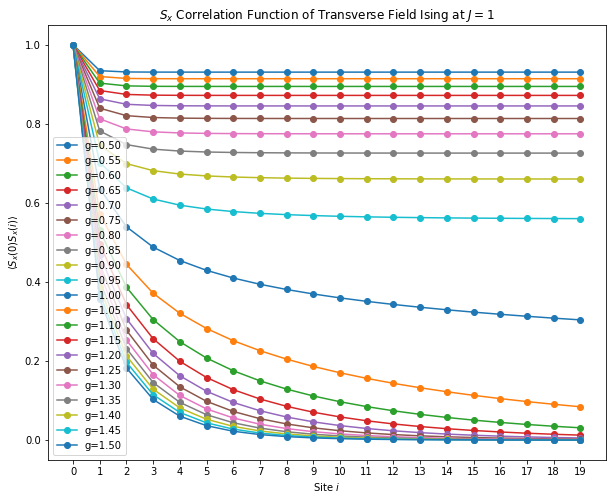

In [70]:
SxSx_list = results['SxSx']
gs = results['gs']
plt.figure(figsize=(10,8))
for g, SxSx in zip(gs, SxSx_list):
    plt.plot(SxSx, 'o-', label=f'g={g:.2f}')
    plt.legend()
plt.xticks(range(20))
plt.xlabel(r'Site $i$')
plt.ylabel(r'$\langle S_x(0) S_x(i)\rangle$')
plt.title(r'$S_x$ Correlation Function of Transverse Field Ising at $J=1$')
plt.show()

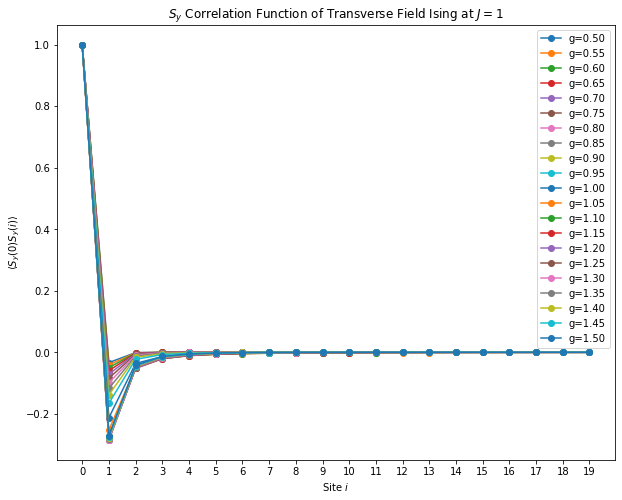

In [72]:

plt.figure(figsize=(10,8))
for g, psi in zip(gs, results['psi_list']):
    SySy = psi.correlation_function("Sigmay", "Sigmay", [0], 20)[0, :]
    plt.plot(SySy, 'o-', label=f'g={g:.2f}')
    plt.legend()
plt.xticks(range(20))
plt.xlabel(r'Site $i$')
plt.ylabel(r'$\langle S_y(0) S_y(i)\rangle$')
plt.title(r'$S_y$ Correlation Function of Transverse Field Ising at $J=1$')
plt.show()

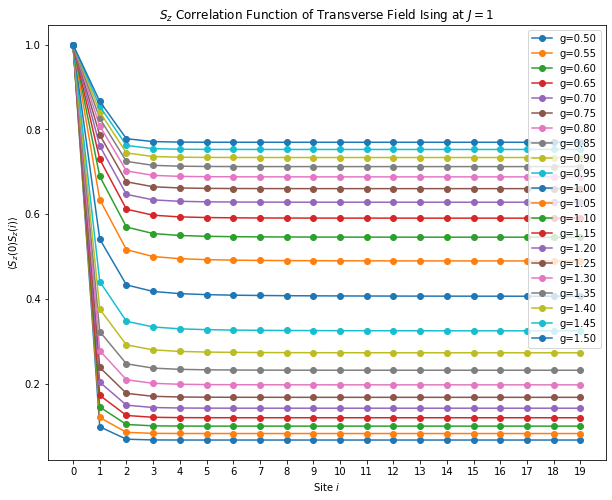

In [74]:

plt.figure(figsize=(10,8))
for g, psi in zip(gs, results['psi_list']):
    SzSz = psi.correlation_function("Sigmaz", "Sigmaz", [0], 20)[0, :]
    plt.plot(SzSz, 'o-', label=f'g={g:.2f}')
    plt.legend()
plt.xticks(range(20))
plt.xlabel(r'Site $i$')
plt.ylabel(r'$\langle S_z(0) S_z(i)\rangle$')
plt.title(r'$S_z$ Correlation Function of Transverse Field Ising at $J=1$')
plt.show()

## Correlation Function

Reading 'bc_MPS'='infinite' for config TFIChain
Reading 'conserve'='best' for config TFIChain
TFIChain: set conserve to parity
Reading 'L'=2 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=0.5 for config TFIChain
Subconfig 'trunc_params'=Config(<4 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=5 for config TwoSiteDMRGEngine
Updating environment
.....
--------------------------------------------------------------------------------
g = 0.5
--------------------------------------------------------------------------------
Reading 'explicit_plus_hc'=False for config TFIChain
Reading 'bc_MPS'='infinite' for config TFIChain
Reading 'order'='default' for config TFIChain
Reading 'conserve'='best' for config TFIChain
TFIChain: set conserve to parity
Reading 'bc_x'='periodic' for config TFIChain
Reading 'L'=2 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=0.5 for config TFIChain
Reading 'sort_mpo_legs'=False for

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'max_sweeps'=100 for config TwoSiteDMRGEngine
Reading 'max_E_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'update_env'=5 for config TwoSiteDMRGEngine
Reading 'mixer'=False for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = -1.0635444099733959, S = 0.6960673544910864, norm_err = 2.3e-15
Current memory usage 141.6 MB, time elapsed: 0.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 5.1195e-21, max_E_trunc = 2.8422e-14
MPS bond dimensions: [20, 20]
Updating environment
.....
sweep 20, age = 320
Energy = -1.0635444099734315, S = 0.6960673544910714, norm_err = 8.4e-16
Current memory usage 141.6 MB, time elapsed: 1.2 s
Delta E = -3.5527e-15, Delta S = -1.4988e-15 (per sweep)
max_trunc_err = 4.0803e-21, max_E_trunc = 1.1369e-13
MPS bond dimensions: [20, 20]
DMRG finished after 20 sweeps.
total size = 320, maximum chi = 20
corr. length 1.4117252256884814
<Sigmaz> [0.2586579 0.25865

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


NameError: name 'g' is not defined

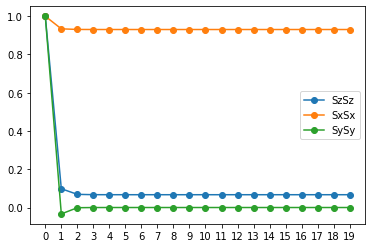

In [7]:
results = DMRG_Ising(g=.5)
psi = results['psi']
zz_func = psi.correlation_function("Sigmaz", "Sigmaz", [0], 20)[0]
xx_func = psi.correlation_function("Sigmax", "Sigmax", [0], 20)[0]
yy_func = psi.correlation_function("Sigmay", "Sigmay", [0], 20)[0]

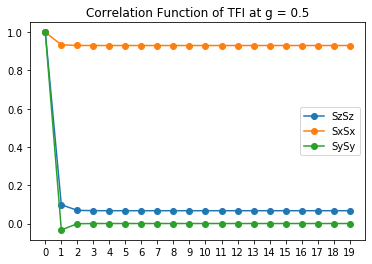

In [8]:
g=.5
plt.plot(range(20), zz_func, 'o-', label='SzSz')
plt.plot(range(20), xx_func, 'o-', label='SxSx')
plt.plot(range(20), yy_func, 'o-', label='SySy')
plt.xticks(range(20))
plt.legend()
plt.title(f'Correlation Function of TFI at g = {g}')
plt.show()

In [15]:
g=5
results = DMRG_Ising(g=g,max_sweeps=10000, mixer=True)
psi = results['psi']
zz_func = psi.correlation_function("Sigmaz", "Sigmaz", [0], 20)[0]
xx_func = psi.correlation_function("Sigmax", "Sigmax", [0], 20)[0]
yy_func = psi.correlation_function("Sigmay", "Sigmay", [0], 20)[0]

Reading 'bc_MPS'='infinite' for config TFIChain
Reading 'conserve'='best' for config TFIChain
TFIChain: set conserve to parity
Reading 'L'=2 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=5 for config TFIChain
Subconfig 'trunc_params'=Config(<4 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=5 for config TwoSiteDMRGEngine
Updating environment
.....
--------------------------------------------------------------------------------
g = 5
--------------------------------------------------------------------------------
Reading 'explicit_plus_hc'=False for config TFIChain
Reading 'bc_MPS'='infinite' for config TFIChain
Reading 'order'='default' for config TFIChain
Reading 'conserve'='best' for config TFIChain
TFIChain: set conserve to parity
Reading 'bc_x'='periodic' for config TFIChain
Reading 'L'=2 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=5 for config TFIChain
Reading 'sort_mpo_legs'=False for confi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['bc'] for config TFIChain

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


.
Reading 'max_sweeps'=10000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'update_env'=5 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 200
Energy = 0.5774078035450430, S = nan, norm_err = 9.3e-02
Current memory usage 157.7 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9223e-09, max_E_trunc = -8.3446e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 20, age = 320
Energy = 1.0213359600521983, S = nan, norm_err = 3.3e-02
Current memory usage 157.7 MB, time elapsed: 5.7 s
Delta E = 4.4393e-02, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7628e-09, max_E_trunc = -2.4443e-11
MPS bond dimensions: [88, 100]
Convergence criterium reached with enabled mixer.
disa

Updating environment
.....
sweep 210, age = 2600
Energy = 0.5847255317610234, S = 0.7222395698552916, norm_err = 3.4e-01
Current memory usage 158.0 MB, time elapsed: 60.0 s
Delta E = -1.9785e-01, Delta S = 3.7451e-02 (per sweep)
max_trunc_err = 3.1952e-10, max_E_trunc = -1.8190e-12
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 220, age = 2720
Energy = 14.1556295107525330, S = 0.3448901281549697, norm_err = 9.3e-01
Current memory usage 158.0 MB, time elapsed: 63.0 s
Delta E = 1.3571e+00, Delta S = -3.7735e-02 (per sweep)
max_trunc_err = 2.1514e-11, max_E_trunc = -1.0914e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 230, age = 2840
Energy = -1.3484898700992289, S = 0.6497167471383634, norm_err = 7.3e-01
Current memory usage 158.0 MB, time elapsed: 66.0 s
Delta E = -1.5504e+00, Delta S = 3.0483e-02 (per sweep)
max_trunc_err = 1.8765e-09, max_E_trunc = -1.8159e-08
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 240, age = 2960
Ener

Updating environment
.....
sweep 420, age = 5120
Energy = -0.0346162647620076, S = 0.0037059487963895, norm_err = 3.9e-04
Current memory usage 158.5 MB, time elapsed: 123.6 s
Delta E = -1.4244e-02, Delta S = -1.8136e-03 (per sweep)
max_trunc_err = 2.8165e-11, max_E_trunc = -2.0736e-10
MPS bond dimensions: [99, 98]
Updating environment
.....
sweep 430, age = 5240
Energy = -1.4065919804493205, S = 0.1714913502176894, norm_err = 1.3e-01
Current memory usage 158.5 MB, time elapsed: 126.5 s
Delta E = -1.3720e-01, Delta S = 1.6779e-02 (per sweep)
max_trunc_err = 1.0553e-09, max_E_trunc = -4.0018e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 440, age = 5360
Energy = 1.1263554605025092, S = 0.0025194214066806, norm_err = 7.4e-03
Current memory usage 158.5 MB, time elapsed: 129.4 s
Delta E = 2.5329e-01, Delta S = -1.6897e-02 (per sweep)
max_trunc_err = 4.4729e-09, max_E_trunc = -4.2783e-09
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 450, age = 5480
En

Updating environment
.....
sweep 630, age = 7640
Energy = 0.0189743529003863, S = 0.0043031748114634, norm_err = 7.0e-05
Current memory usage 158.9 MB, time elapsed: 184.2 s
Delta E = 9.7591e-01, Delta S = -5.2095e-02 (per sweep)
max_trunc_err = 1.3783e-09, max_E_trunc = -6.8394e-10
MPS bond dimensions: [97, 96]
Updating environment
.....
sweep 640, age = 7760
Energy = -0.1033184556263222, S = 0.0165965553737137, norm_err = 7.6e-04
Current memory usage 158.9 MB, time elapsed: 187.0 s
Delta E = -1.2229e-02, Delta S = 1.2293e-03 (per sweep)
max_trunc_err = 2.0131e-10, max_E_trunc = 0.0000e+00
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 650, age = 7880
Energy = 0.1396742143333540, S = 0.2254868833645085, norm_err = 8.8e-01
Current memory usage 158.9 MB, time elapsed: 189.9 s
Delta E = 2.4299e-02, Delta S = 2.0889e-02 (per sweep)
max_trunc_err = 7.6307e-10, max_E_trunc = -7.0941e-10
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 660, age = 8000
Energy

Updating environment
.....
sweep 840, age = 10160
Energy = -0.1987947059678845, S = 0.0715943793375325, norm_err = 1.1e-01
Current memory usage 159.5 MB, time elapsed: 243.8 s
Delta E = -6.2565e-01, Delta S = -5.1366e-02 (per sweep)
max_trunc_err = 1.0954e-09, max_E_trunc = -1.5207e-09
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 850, age = 10280
Energy = 1.0655947539817134, S = 0.5516624616386685, norm_err = 4.9e-02
Current memory usage 159.5 MB, time elapsed: 246.5 s
Delta E = 1.2644e-01, Delta S = 4.8007e-02 (per sweep)
max_trunc_err = 1.7824e-09, max_E_trunc = -5.8208e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 860, age = 10400
Energy = 0.0895119524184338, S = 0.0115952700717882, norm_err = 6.0e-02
Current memory usage 159.5 MB, time elapsed: 249.4 s
Delta E = -9.7608e-02, Delta S = -5.4007e-02 (per sweep)
max_trunc_err = 1.6604e-09, max_E_trunc = -1.0041e-09
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 870, age = 105

Updating environment
.....
sweep 1050, age = 12680
Energy = -5.0048804286880113, S = 0.4081751178046991, norm_err = 9.8e-01
Current memory usage 160.1 MB, time elapsed: 302.7 s
Delta E = -9.3793e-01, Delta S = 1.1845e-02 (per sweep)
max_trunc_err = 1.0436e-09, max_E_trunc = 0.0000e+00
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1060, age = 12800
Energy = -1.3262740813552227, S = 1.0260675604252110, norm_err = 4.3e-01
Current memory usage 160.1 MB, time elapsed: 305.5 s
Delta E = 3.6786e-01, Delta S = 6.1789e-02 (per sweep)
max_trunc_err = 2.7397e-09, max_E_trunc = -7.2760e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1070, age = 12920
Energy = 0.8985582642462759, S = 0.9135134309843036, norm_err = 5.0e-01
Current memory usage 160.1 MB, time elapsed: 308.4 s
Delta E = 2.2248e-01, Delta S = -1.1255e-02 (per sweep)
max_trunc_err = 4.1517e-10, max_E_trunc = -4.3656e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1080, age = 1

Updating environment
.....
sweep 1260, age = 15200
Energy = 4.8817734118965745, S = 2.1816998584714860, norm_err = 1.2e-01
Current memory usage 160.6 MB, time elapsed: 362.0 s
Delta E = 8.9242e-02, Delta S = 1.4781e-01 (per sweep)
max_trunc_err = 2.1737e-08, max_E_trunc = -6.6211e-10
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1270, age = 15320
Energy = 0.1084265376975964, S = 1.2337119253697724, norm_err = 6.0e-01
Current memory usage 160.6 MB, time elapsed: 364.9 s
Delta E = -4.7733e-01, Delta S = -9.4799e-02 (per sweep)
max_trunc_err = 4.5293e-10, max_E_trunc = 7.2760e-12
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1280, age = 15440
Energy = -5.0048193837728832, S = 0.4177550367523746, norm_err = 9.5e-01
Current memory usage 160.6 MB, time elapsed: 367.6 s
Delta E = -5.1132e-01, Delta S = -8.1596e-02 (per sweep)
max_trunc_err = 2.9606e-09, max_E_trunc = -7.2760e-12
MPS bond dimensions: [98, 98]
Updating environment
.....
sweep 1290, age = 15

Updating environment
.....
sweep 1470, age = 17720
Energy = -0.1758130391917803, S = 1.2117818579366770, norm_err = 1.2e-01
Current memory usage 161.2 MB, time elapsed: 420.8 s
Delta E = 4.8647e-01, Delta S = 8.3304e-02 (per sweep)
max_trunc_err = 5.3072e-09, max_E_trunc = -2.7343e-08
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1480, age = 17840
Energy = -0.1346170095985144, S = 0.0099758854604533, norm_err = 6.0e-03
Current memory usage 161.2 MB, time elapsed: 423.7 s
Delta E = 4.1196e-03, Delta S = -1.2018e-01 (per sweep)
max_trunc_err = 3.9454e-09, max_E_trunc = -1.1642e-10
MPS bond dimensions: [100, 95]
Updating environment
.....
sweep 1490, age = 17960
Energy = 0.2907425589546619, S = 0.1655124910893193, norm_err = 4.2e-02
Current memory usage 161.2 MB, time elapsed: 426.5 s
Delta E = 4.2536e-02, Delta S = 1.5554e-02 (per sweep)
max_trunc_err = 1.4902e-10, max_E_trunc = 3.6380e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1500, age = 180

Updating environment
.....
sweep 1680, age = 20240
Energy = 4.2037479511564015, S = 0.8179523579829715, norm_err = 4.0e-01
Current memory usage 161.8 MB, time elapsed: 479.7 s
Delta E = 1.2017e+00, Delta S = 7.8095e-02 (per sweep)
max_trunc_err = 1.8127e-09, max_E_trunc = -2.6514e-08
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1690, age = 20360
Energy = 0.0201803324853245, S = 0.0017596004555476, norm_err = 1.2e-03
Current memory usage 161.8 MB, time elapsed: 482.5 s
Delta E = -4.1836e-01, Delta S = -8.1619e-02 (per sweep)
max_trunc_err = 6.1364e-10, max_E_trunc = 1.4552e-11
MPS bond dimensions: [95, 94]
Updating environment
.....
sweep 1700, age = 20480
Energy = 0.6073739109524467, S = 0.9668343964543190, norm_err = 8.9e-01
Current memory usage 161.8 MB, time elapsed: 485.3 s
Delta E = 5.8719e-02, Delta S = 9.6507e-02 (per sweep)
max_trunc_err = 8.9973e-09, max_E_trunc = -7.7125e-10
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1710, age = 20600

Updating environment
.....
sweep 1890, age = 22760
Energy = 0.5680883491149871, S = 0.4776157609501659, norm_err = 1.1e+00
Current memory usage 162.3 MB, time elapsed: 538.5 s
Delta E = 8.1509e-02, Delta S = 7.0615e-03 (per sweep)
max_trunc_err = 2.0107e-10, max_E_trunc = -4.3656e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1900, age = 22880
Energy = -0.6301707153234020, S = 0.0102586264917352, norm_err = 7.5e-03
Current memory usage 162.4 MB, time elapsed: 541.3 s
Delta E = -1.1983e-01, Delta S = -4.6736e-02 (per sweep)
max_trunc_err = 3.0579e-10, max_E_trunc = -2.9104e-11
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1910, age = 23000
Energy = -0.1045471662473574, S = 0.1019866392878707, norm_err = 5.0e-01
Current memory usage 162.4 MB, time elapsed: 544.2 s
Delta E = 5.2562e-02, Delta S = 9.1728e-03 (per sweep)
max_trunc_err = 4.5881e-09, max_E_trunc = -1.5105e-08
MPS bond dimensions: [100, 100]
Updating environment
.....
sweep 1920, age = 

KeyboardInterrupt: 

In [ ]:
plt.plot(range(20), zz_func, 'o-', label='SzSz')
plt.plot(range(20), xx_func, 'o-', label='SxSx')
plt.plot(range(20), yy_func, 'o-', label='SySy')
plt.xticks(range(20))
plt.legend()
plt.title(f'Correlation Function of TFI at g = {g}')
plt.show()

## Questions

The usage of conserved leads to the unstable results?...